We are going to use sdeint library to integrate the stochastic differential equations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set();

import sdeint
from scipy.integrate import solve_ivp

from tqdm import tqdm

We are going to add white noise only to the X coordinate. F(X,t) is the deterministic part of the equations and G(X,t) the stochastic. We can control which system to integrate by changing the values of l,o, a and b and we can control de amount of noise by changing sigma.

In [2]:
def close(func, *args):
    def newfunc(x, t):
        return func(x, t, *args)
    return newfunc

def F(X, t, l, o, a, b):
    
    x = X[0]
    y = X[1]
    
    r2 = x**2 + y**2
    
    dx = x*(l - b*r2) - y*(o + a*r2)
    dy = x*(o + a*r2) + y*(l - b*r2)
    
    return np.array([dx, dy])

def G(X, t):
    return B

tspan = np.linspace(0.0, 30.0, 30001)
X0 = np.array([0.005, 0.0])

l = 1
o = 1
a = 1
b = 1
params = [l, o, a, b]

sigma = 0.1
B = np.diag([sigma, 0.0])

result = sdeint.itoint(close(F,*params) , G, X0, tspan)

By putting the initial conditions close to (0,0), it is possible to observe the transient and how the trajectory moves towards the limit cycle

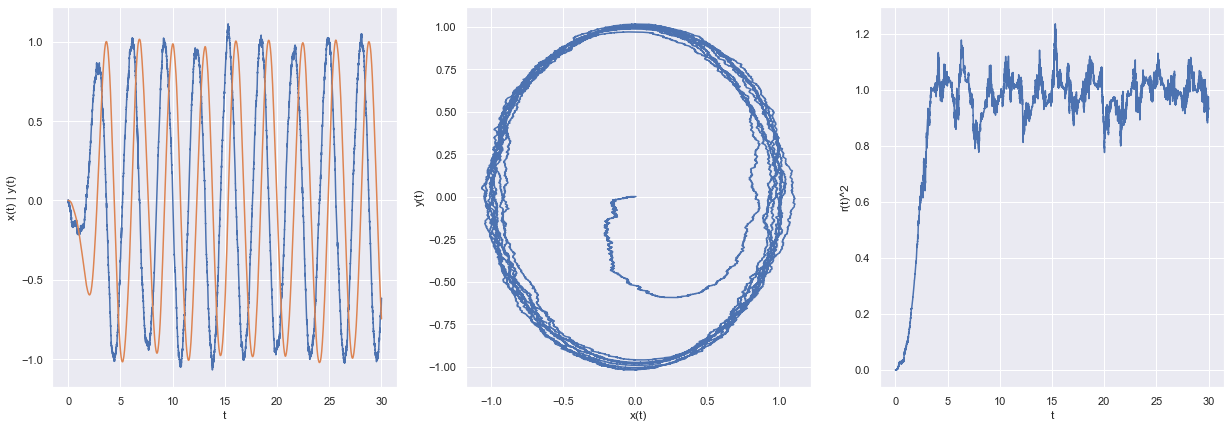

In [3]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize=(21,7))

#X,Y vs t
ax[0].plot(tspan, result)
ax[0].set(xlabel = 't', ylabel = 'x(t) | y(t)')
ax[1].plot(result[:,0],result[:,1])
ax[1].set(xlabel = 'x(t)', ylabel = 'y(t)')
ax[2].plot(tspan, result[:,0]**2 + result[:,1]**2)
ax[2].set(xlabel = 't', ylabel = 'r(t)^2')

plt.show()

Now, putting the system in the limit cycle by initializing with x0 = (1,0) and observe effect of the noise

In [91]:
tspan = np.linspace(0.0, 30.0, 30001)
X0 = np.array([1, 0.0])

l = 0.25
o = 1
a = 1
b = 0.25
params = [l, o, a, b]

sigma = 0.1
B = np.diag([sigma, 0.0])

result = sdeint.itoint(close(F,*params) , G, X0, tspan)

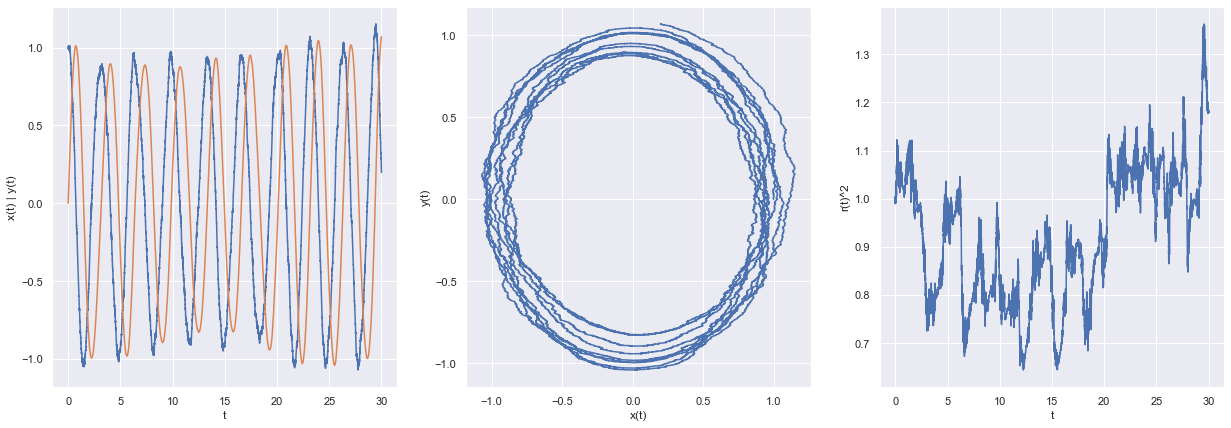

In [92]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize=(21,7))

#X,Y vs t
ax[0].plot(tspan, result)
ax[0].set(xlabel = 't', ylabel = 'x(t) | y(t)')
ax[1].plot(result[:,0],result[:,1])
ax[1].set(xlabel = 'x(t)', ylabel = 'y(t)')
ax[2].plot(tspan, result[:,0]**2 + result[:,1]**2)
ax[2].set(xlabel = 't', ylabel = 'r(t)^2')

plt.show()

Let's build 100 realizations to observe the map

In [81]:
def realization():
    tspan = np.linspace(0.0, 30.0, 30001)
    X0 = np.array([1, 0.0])

    l = 1
    o = 1
    a = 1
    b = 1
    params = [l, o, a, b]

    sigma = 0.1
    B = np.diag([sigma, 0.0])

    return sdeint.itoint(close(F,*params) , G, X0, tspan)

rs = []
for _ in tqdm(range(100)):
    r = realization()
    rs.append(r)

100%|██████████| 100/100 [02:41<00:00,  1.61s/it]


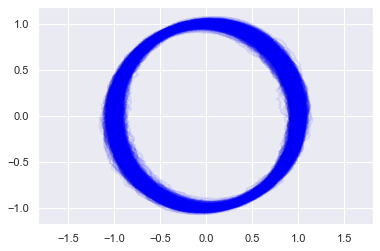

In [88]:
fig, ax = plt.subplots()
for r in rs:
    ax.plot(r[:,0], r[:,1], color = 'blue', alpha = 0.1 )
ax.axis('equal')
plt.show()

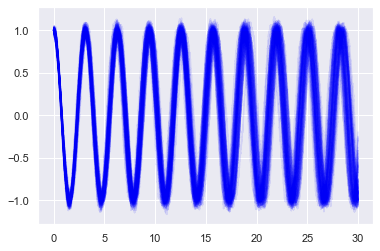

In [90]:
fig, ax = plt.subplots()
for r in rs:
    ax.plot(tspan, r[:,0], color = 'blue', alpha = 0.1 )
plt.show()

The main questions is to see if it is possible to extract the different combinations of lambda and b (for the same LC) by observing the noised trajectories. Let's create 100 realizations for different lambda

In [229]:
def realization_with_params(l, o, a, b, sigma):
    tspan = np.linspace(0.0, 30.0, 30001)
    X0 = np.array([1, 0.0])

    params = [l, o, a, b]

    sigma = sigma
    B = np.diag([sigma, 0.0])

    return sdeint.itoint(close(F,*params) , G, X0, tspan)

In [235]:
lams = [0.25, 0.5, 1, 2, 5]

rs_lam = {}

for lam in lams:
    rs = []
    for _ in tqdm(range(1000)):
        r = realization_with_params(lam, 1, 1, lam, sigma)
        rs.append(r)
    rs_lam[lam] = rs

100%|██████████| 1000/1000 [28:01<00:00,  1.68s/it]


# Save the pickle of the data

In [243]:
import pickle

pickle.dump(rs_lam, open( "multiples_corridas.p", "wb" ))

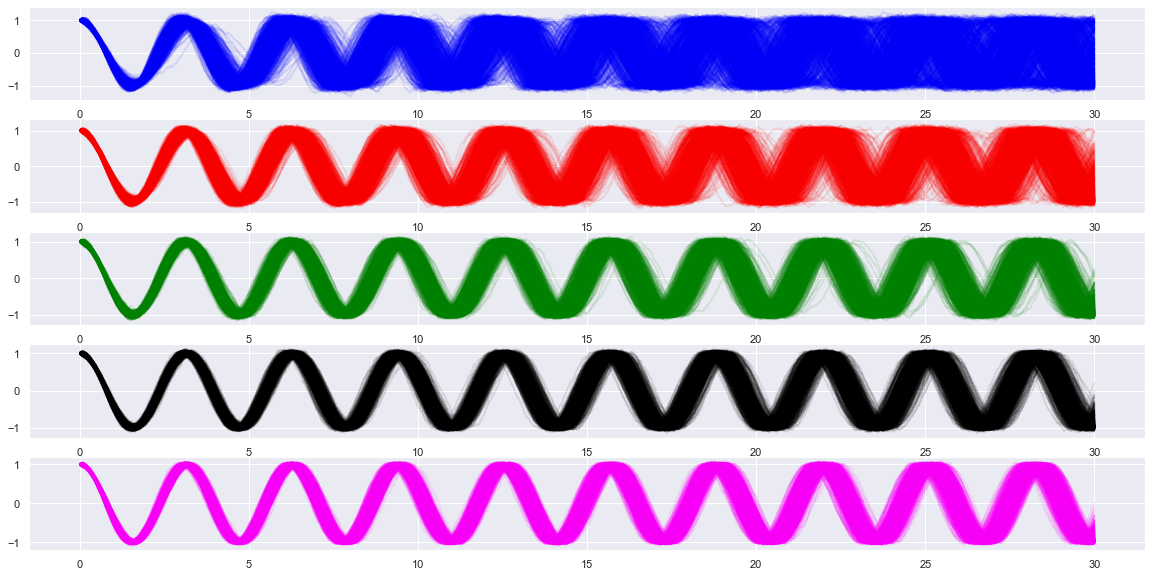

In [236]:
fig, axs = plt.subplots(5, figsize=(20,10))
colors = ['blue', 'red', 'green', 'black', 'magenta']

for i, rs in enumerate(rs_lam):
    for r in rs_lam[rs]:
        axs[i].plot(tspan, r[:,0], color = colors[i], alpha = 0.1 )
plt.show()

In [320]:
def mean_trajectory(trajs):
    N = len(trajs)
    x_vals = np.zeros((len(trajs[0]),N))
    y_vals = np.zeros((len(trajs[0]),N))
    #Extract x coordinate
    for i, x in enumerate(trajs):
        x_vals[:,i] = x[:,0]
        y_vals[:,i] = x[:,1]    
    #calculate mean trajectory
    mean_traj_x = np.mean(x_vals, axis = 1)
    mean_traj_y = np.mean(y_vals, axis = 1)
    
    #calculates the mean root mean square deviation for the complete set
    rms = 0
    x_diff = (x_vals - mean_traj_x.reshape(len(x_vals),1))**2
    y_diff = (y_vals - mean_traj_y.reshape(len(y_vals),1))**2
    return [mean_traj_x, mean_traj_y, x_diff, y_diff]

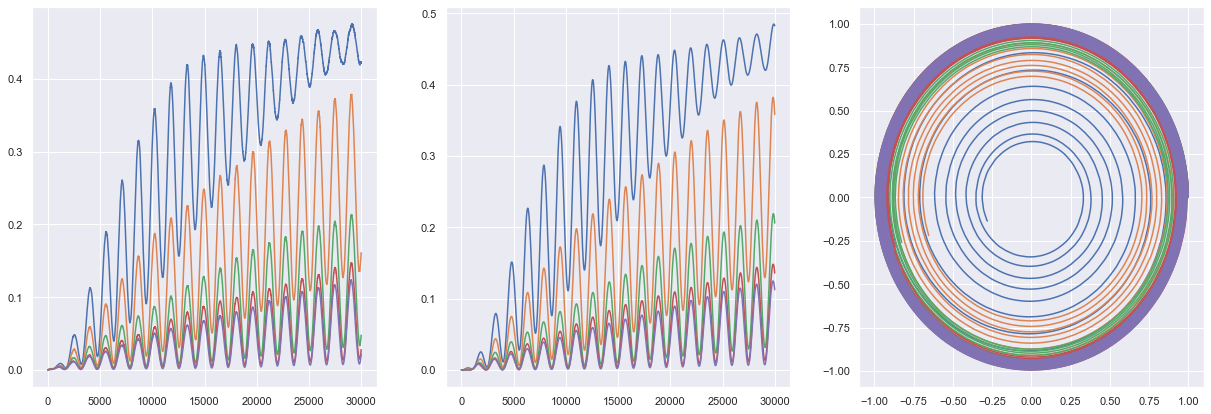

In [323]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (21,7))
for i in rs_lam.keys():
    mx, my, xd, yd  = mean_trajectory(rs_lam[i])
    ax1.plot(np.mean(xd, axis = 1), label = i)
    ax2.plot(np.mean(yd, axis = 1), label = i)
    ax3.plot(mx, my, label = i)
plt.show()

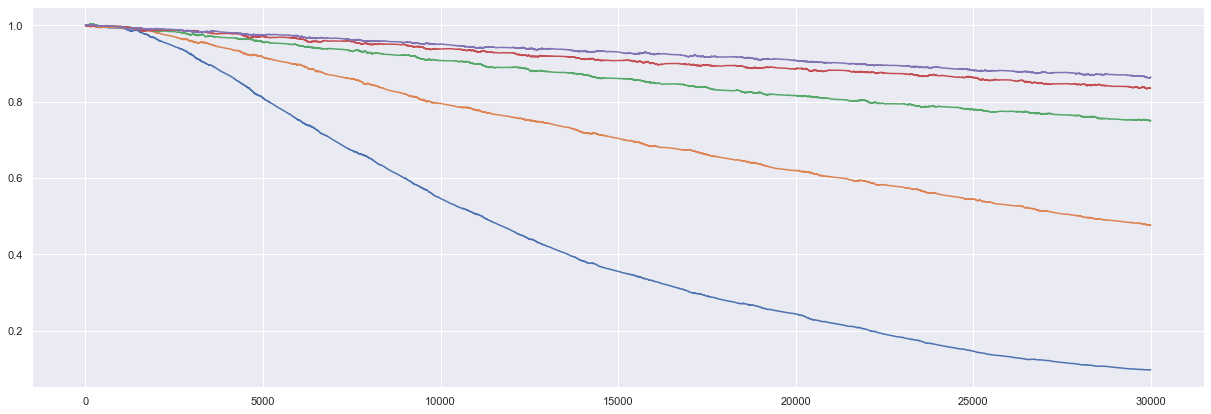

In [332]:
fig, ax = plt.subplots(figsize = (21,7))
for i in rs_lam.keys():
    mx, my, xd, yd  = mean_trajectory(rs_lam[i])
    ax.plot(mx**2 + my**2, label = i)
plt.show()

In [330]:
mean_trajs = {}
for i in rs_lam.keys():
    mx, my, xd, yd  = mean_trajectory(rs_lam[i])
    mean_trajs[i] = [mx,my]

In [411]:
from scipy.optimize import fsolve, curve_fit

def sigmoid(x, x0, k):
    """
    Sigmoid function between 0 and 1, variable slope k and x0 midpoint position
    """
    return 1 / (1 + np.exp(-k*(x-x0)))

def sigmoid2(x, x0, k, h):
    """
    Sigmoid function between 0 and h, variable slope k and x0 midpoint position
    """
    return h / (1 + np.exp(-k*(x-x0)))

def monoexp(x, A, k):
    return A*np.exp(-k*x)

def biexp(x, A, k1, B, k2):
    return A*np.exp(-k1*x) + B*np.exp(-k2*x)

# Non-linear curve fitting using sigmoid function
def fit_r(func, x_data, y_data):
    
    if func == sigmoid:
        p0 = [np.median(x_data),1] # this is an mandatory initial guess
    elif func == sigmoid2:
        p0 = [np.median(x_data),1, np.max(y_data)] # this is an mandatory initial guess
    elif func == monoexp:
        p0 = [1, -1] # this is an mandatory initial guess
    elif func == biexp:
        p0 = [1, 1, 2, 0.5] # this is an mandatory initial guess

        
    popt, _ = curve_fit(func, x_data, y_data, p0)
    
    return popt

[-0.32313752  0.40608622  1.31771731  0.08663066]


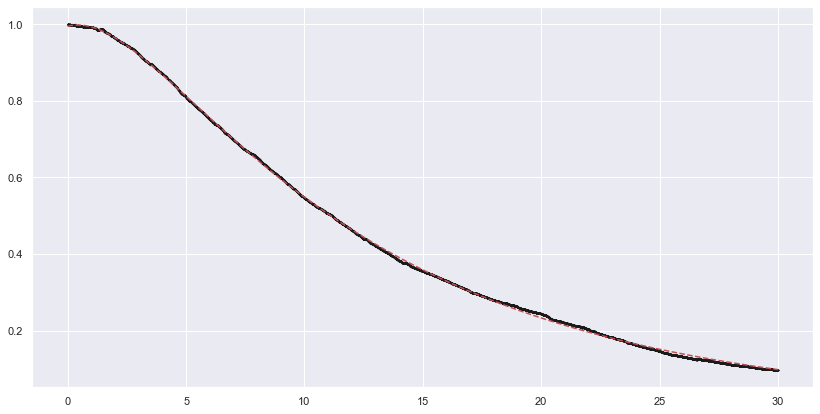

In [412]:
r2_025 = (mean_trajs[0.25][0])**2+(mean_trajs[0.25][1])**2
popt = fit_r(biexp, tspan, r2_025)
print(popt)

fig, ax = plt.subplots(figsize=(14,7))
plt.plot(tspan, r2_025, 'k.', alpha = 0.5, markersize = 1)
plt.plot(tspan, biexp(tspan, *popt), 'r', linestyle = '--');

[1.03213316 0.025573  ]


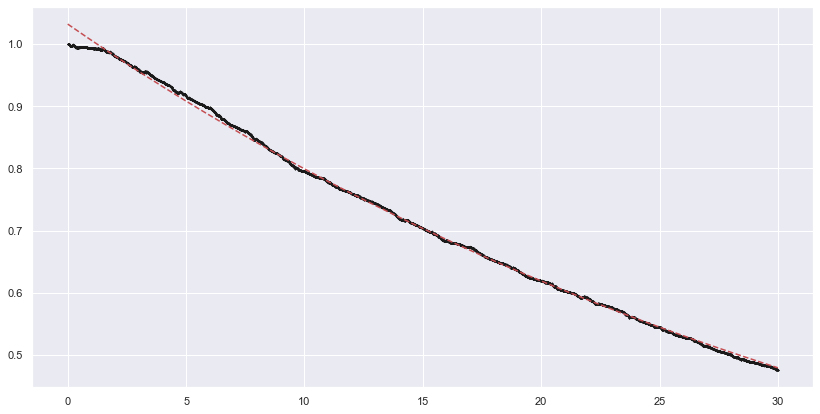

In [413]:
r2_05 = (mean_trajs[0.5][0])**2+(mean_trajs[0.5][1])**2
popt = fit_r(monoexp, tspan, r2_05)
print(popt)

fig, ax = plt.subplots(figsize=(14,7))
plt.plot(tspan, r2_05, 'k.', alpha = 0.5, markersize = 1)
plt.plot(tspan, monoexp(tspan, *popt), 'r', linestyle = '--');

[1.00516078 0.01018618]


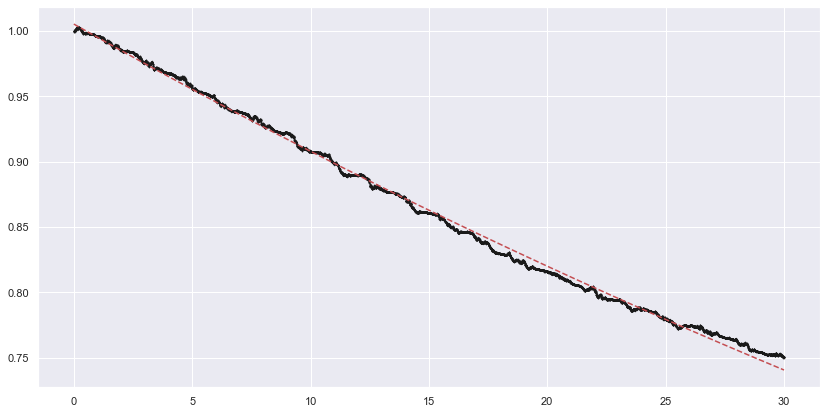

In [414]:
r2_1 = (mean_trajs[1][0])**2+(mean_trajs[1][1])**2
popt = fit_r(monoexp, tspan, r2_1)
print(popt)

fig, ax = plt.subplots(figsize=(14,7))
plt.plot(tspan, r2_1, 'k.', alpha = 0.5, markersize = 1)
plt.plot(tspan, monoexp(tspan, *popt), 'r', linestyle = '--');

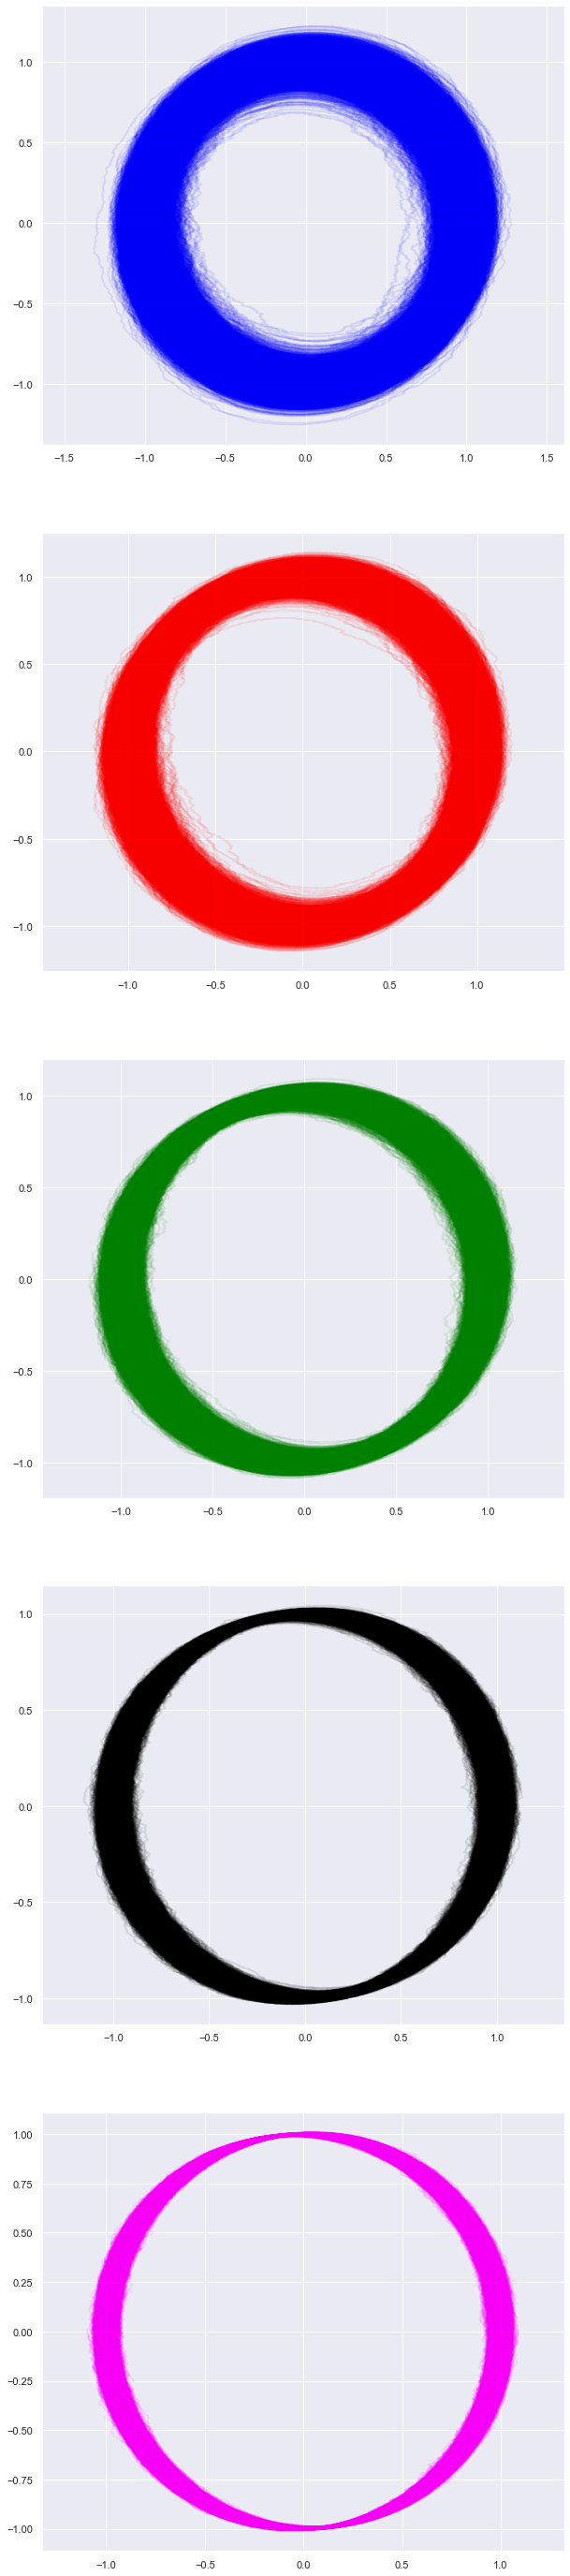

In [249]:
fig, axs = plt.subplots(5, figsize=(10,50))
colors = ['blue', 'red', 'green', 'black', 'magenta']

for i, rs in enumerate(rs_lam):
    for r in rs_lam[rs]:
        axs[i].plot(r[:,0], r[:,1], color = colors[i], alpha = 0.1 )
    axs[i].axis('equal')
plt.show()

## Given the realizations, can we construct the nullclines, at least partially?

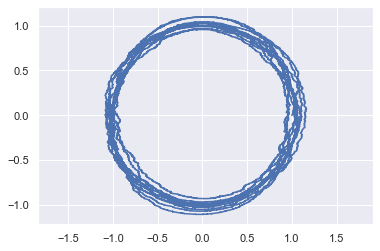

In [272]:
data_x = rs_lam[0.25][0][:,0]
data_y = rs_lam[0.25][0][:,1]
#res = TVRegDiff(data, 1000, 0.2, u0=None, scale='large', ep=1e-6, dx=None, plotflag=_has_matplotlib, diagflag=True)
plt.plot(data_x, data_y)
plt.axis('equal')
plt.show()

In [303]:
data_x = pd.Series(data_x)
data_y = pd.Series(data_y)

In [304]:
data_x.index = pd.timedelta_range(0, periods=30001, freq='L')
data_y.index = pd.timedelta_range(0, periods=30001, freq='L')

In [313]:
data_x_diff = data_x.diff().mul(1000).rolling(window=100, win_type='boxcar').mean()

In [314]:
data_dx = data_x*(0.25 - 0.25*(data_x**2 + data_y**2)) - data_y*(1 + 1*(data_x**2 + data_y**2))

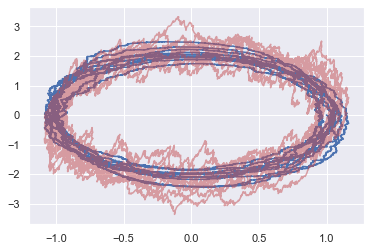

In [319]:
plt.plot(data_x, data_dx, 'b', alpha = 1)
plt.plot(data_x, data_x_diff,'r', alpha = 0.5)